# Setup

In [1]:
%%capture
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install fiona
!pip install geopandas
!pip install PyCRS
!pip install -i https://test.pypi.org/simple/ gis-utils-pkg-dillhicks==0.0.76


import os
from tqdm.autonotebook import tqdm
import numpy as np
import gis_utils.raster as raster
from rasterio.plot import reshape_as_image
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Data


In [3]:
!cp /content/drive/MyDrive/srcnn/seg_tiles.zip .
!unzip seg_tiles.zip -y

Archive:  seg_tiles.zip
caution: filename not matched:  -y


In [4]:
from cv2 import resize
import cv2


def load_data(input_dir):
    lr_image_filenames = [os.path.join(input_dir, x) for x in os.listdir(input_dir) if x.endswith(".tif") and x.startswith("S2_")]

    hr_image_filenames = [os.path.join(input_dir,"hr_" + os.path.split(x)[1]) for x in lr_image_filenames]
    #Loading LR tiles (getting filenames with "hr_" removed)
    label_filenames = [os.path.join(input_dir,"label_hr_" + os.path.split(x)[1]) for x in lr_image_filenames]

    print(label_filenames)
    labels = []
    hr_images = []
    lr_images = []

    label_meta = []
    hr_image_meta = []
    lr_image_meta = []

    transforms = []
    for index in tqdm(range(len(lr_image_filenames))):
        

        label, label_meta_cur = raster.load_image(label_filenames[index])
        lr_image, lr_image_meta_cur = raster.load_image(lr_image_filenames[index])
        hr_image, hr_image_meta_cur = raster.load_image(hr_image_filenames[index])
                
        labels.append(np.squeeze(reshape_as_image(label.read())))
        lr_images.append(resize(reshape_as_image(lr_image.read()), (48,48), interpolation = cv2.INTER_AREA))
        hr_images.append(np.squeeze(reshape_as_image(hr_image.read())))
        
        
        label_meta.append(label_meta_cur)
        lr_image_meta.append(lr_image_meta_cur)
        hr_image_meta.append(hr_image_meta_cur)
        transforms.append(hr_image.transform)

    return labels, lr_images, hr_images, label_meta, lr_image_meta, hr_image_meta, lr_image_filenames, hr_image_filenames, label_filenames, transforms

In [5]:
# labels_train, lr_images_train, hr_images_train,\
# labels_train_meta, lr_images_train_meta, hr_images_train_meta,\
# lr_images_train_filenames, hr_images_train_filenames,\
# labels_train_filenames, hr_train_transforms = load_data("train")

labels_test, lr_images_test, hr_images_test,\
labels_test_meta, lr_images_test_meta, hr_images_test_meta,\
lr_images_test_filenames, hr_images_test_filenames,\
labels_test_filenames, hr_test_transforms = load_data("test")

# labels_train = np.asarray(labels_train)
# lr_images_train = np.asarray(lr_images_train)
# hr_images_train = np.asarray(hr_images_train)

labels_test = np.asarray(labels_test)
lr_images_test = np.asarray(lr_images_test)
hr_images_test = np.asarray(hr_images_test)


['test/label_hr_S2_psc_2018-07_site11_planetscope_optical_02_08.tif', 'test/label_hr_S2_psc_2018-07_site10_planetscope_optical_2_2.tif', 'test/label_hr_S2_psc_2018-07_site11_planetscope_optical_03_12.tif', 'test/label_hr_S2_psc_2018-07_site11_planetscope_optical_08_08.tif', 'test/label_hr_S2_psc_2018-07_site10_planetscope_optical_5_3.tif', 'test/label_hr_S2_psc_2018-07_site11_planetscope_optical_02_02.tif', 'test/label_hr_S2_psc_2018-07_site11_planetscope_optical_07_09.tif', 'test/label_hr_S2_psc_2018-07_site11_planetscope_optical_02_01.tif', 'test/label_hr_S2_psc_2018-07_site11_planetscope_optical_05_14.tif', 'test/label_hr_S2_psc_2018-07_site11_planetscope_optical_07_11.tif', 'test/label_hr_S2_psc_2018-07_site11_planetscope_optical_05_07.tif', 'test/label_hr_S2_psc_2018-07_site11_planetscope_optical_10_13.tif', 'test/label_hr_S2_psc_2018-07_site10_planetscope_optical_3_4.tif', 'test/label_hr_S2_psc_2018-07_site10_planetscope_optical_5_6.tif', 'test/label_hr_S2_psc_2018-07_site11_plan

  0%|          | 0/168 [00:00<?, ?it/s]

# Loading Augmented Images

In [6]:
!cp /content/drive/MyDrive/srcnn/segmented.data .

In [7]:
import pickle as pkl


with open('segmented.data', 'rb') as f:
    data = pkl.load(f)

labels_aug = []
lr_aug = []
hr_aug = []

for image in data:
    hr_aug.append(image[0])
    lr_aug.append(image[1])
    labels_aug.append(image[2])

labels_aug = np.asarray(labels_aug)
hr_aug = np.asarray(hr_aug)
lr_aug = np.asarray(lr_aug)

# Loading SRCNN + Generating Data

In [8]:
!cp /content/drive/MyDrive/srcnn/sr_checkpoint.h5 .

from tensorflow.keras.layers import Activation
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

def PSNRLoss(y_true, y_pred):

    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303


srcnn = Sequential()
srcnn.add(Conv2D(64,9,padding='same',input_shape=(48,48,4)))
srcnn.add(Activation('relu'))
srcnn.add(Conv2D(32,1,padding='same'))
srcnn.add(Activation('relu'))
srcnn.add(Conv2D(4,5,padding='same'))
srcnn.compile(optimizer='adam', loss='mean_squared_error', metrics=[PSNRLoss])

In [9]:
srcnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        20800     
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        2080      
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 4)         3204      
                                                                 
Total params: 26,084
Trainable params: 26,084
Non-trainable params: 0
_________________________________________________________________


In [10]:
srcnn.load_weights('/content/sr_checkpoint.h5')

In [11]:
r_train = srcnn.predict(lr_aug)
r_test = srcnn.predict(lr_images_test)

# EfficientUnet


In [12]:
import tensorflow as tf
from tensorflow.keras import layers

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [13]:
import tensorflow as tf

def DeeplabV3Plus(image_size, num_classes):
    model_input = tf.keras.Input(shape=(image_size, image_size, 4))
    resnet50 = tf.keras.applications.ResNet50(
        weights=None, include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return tf.keras.Model(inputs=model_input, outputs=model_output)




In [14]:
from cv2 import resize
import cv2

dlab_hr = np.array([resize(image, (240,240), interpolation = cv2.INTER_AREA) for image in r_train])
dlab_hr_test = np.array([resize(image, (240,240), interpolation = cv2.INTER_AREA) for image in r_test])
dlab_labels = np.array([resize(image, (240,240), interpolation = cv2.INTER_AREA) for image in labels_aug])
dlab_labels_test = np.array([resize(image, (240,240), interpolation = cv2.INTER_AREA) for image in labels_test])

dlab_hr.shape

(2680, 240, 240, 4)

In [15]:
num_classes = 2
tf.keras.backend.clear_session()

sr_model = DeeplabV3Plus(image_size=240, num_classes=num_classes)


sr_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics = ['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('unet_checkpoint_aug.h5', save_best_only = True)

history = sr_model.fit(dlab_hr, dlab_labels,
            epochs=50,
            validation_data=(dlab_hr_test, dlab_labels_test),
            callbacks=[early_stopper, model_checkpoint])


Epoch 1/50
84/84 [==============================] - ETA: 0s - loss: 0.7121 - accuracy: 0.7052

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


84/84 [==============================] - 46s 449ms/step - loss: 0.7121 - accuracy: 0.7052 - val_loss: 0.6966 - val_accuracy: 0.3792
Epoch 2/50
84/84 [==============================] - 34s 410ms/step - loss: 0.5298 - accuracy: 0.7826 - val_loss: 0.6931 - val_accuracy: 0.3809
Epoch 3/50
84/84 [==============================] - 34s 409ms/step - loss: 0.5173 - accuracy: 0.7072 - val_loss: 0.6726 - val_accuracy: 0.6209
Epoch 4/50
84/84 [==============================] - 34s 411ms/step - loss: 0.4925 - accuracy: 0.6276 - val_loss: 0.6362 - val_accuracy: 0.6209
Epoch 5/50
84/84 [==============================] - 34s 409ms/step - loss: 0.4832 - accuracy: 0.6262 - val_loss: 0.5758 - val_accuracy: 0.6209
Epoch 6/50
84/84 [==============================] - 33s 399ms/step - loss: 0.4888 - accuracy: 0.6392 - val_loss: 3.5625 - val_accuracy: 0.6051
Epoch 7/50
84/84 [==============================] - 34s 399ms/step - loss: 0.4437 - accuracy: 0.8062 - val_loss: 0.6090 - val_accuracy: 0.7339
Epoch 8/50

# Mosaicing Visualizations

In [16]:
!cp /content/drive/MyDrive/srcnn/tiles.zip .


!unzip tiles.zip -d testing

Archive:  tiles.zip
replace testing/S2_lap_2018-07_site01_planetscope_optical_1_1.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: testing/S2_lap_2018-07_site01_planetscope_optical_1_1.tif  
  inflating: testing/S2_lap_2018-07_site01_planetscope_optical_1_2.tif  
  inflating: testing/S2_lap_2018-07_site01_planetscope_optical_1_3.tif  
  inflating: testing/S2_lap_2018-07_site01_planetscope_optical_1_4.tif  
  inflating: testing/S2_lap_2018-07_site01_planetscope_optical_2_1.tif  
  inflating: testing/S2_lap_2018-07_site01_planetscope_optical_2_2.tif  
  inflating: testing/S2_lap_2018-07_site01_planetscope_optical_2_3.tif  
  inflating: testing/S2_lap_2018-07_site01_planetscope_optical_2_4.tif  
  inflating: testing/S2_lap_2018-07_site01_planetscope_optical_3_1.tif  
  inflating: testing/S2_lap_2018-07_site01_planetscope_optical_3_2.tif  
  inflating: testing/S2_lap_2018-07_site01_planetscope_optical_3_3.tif  
  inflating: testing/S2_lap_2018-07_site01_planetscope_optical_3_4.tif

In [22]:
from cv2 import resize
import cv2

def load_unresolved(input_dir):
    target_filenames = [os.path.join(input_dir, x) for x in os.listdir(input_dir) if x.endswith(".tif")]
    lr_images = []

    lr_meta = []

    bounds = []
    for index in tqdm(range(len(target_filenames))):
        
        lr_image = rasterio.open(target_filenames[index])
        print(lr_image.read().shape)

                
        lr_images.append(resize(reshape_as_image(lr_image.read()), (48,48), interpolation = cv2.INTER_AREA))
        
        lr_meta.append(lr_image.meta)
        bounds.append(lr_image.bounds)

    return lr_images, lr_meta, target_filenames, bounds

In [29]:
from rasterio.transform import from_bounds

s1_images, s1_meta, s1_files, s1_bounds = load_unresolved("testing")

s1_images = np.asarray(s1_images)
s1_resolved = srcnn.predict(s1_images)

  0%|          | 0/20 [00:00<?, ?it/s]

(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)
(4, 16, 16)


In [30]:
from cv2 import resize
import cv2

ds1_images = np.array([resize(image, (240,240), interpolation = cv2.INTER_AREA) for image in s1_resolved])

In [42]:
img_size = (48, 48)
num_classes = 2
batch_size = 32

# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
sr_model = DeeplabV3Plus(image_size=240, num_classes=num_classes)
sr_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics = ['accuracy'])
sr_model.load_weights('/content/unet_checkpoint_aug.h5')

r_segmented_s1 = sr_model.predict(ds1_images)


r_segmented_s1 = np.argmax(r_segmented_s1, axis = 3)
#r_segmented_s1 = np.argmax(s1_resolved, axis=-1)


res_segmented_s1 = np.array([resize(image.astype('float32'), (48,48), interpolation = cv2.INTER_AREA) for image in r_segmented_s1])

!mkdir sr_testing

mkdir: cannot create directory ‘sr_testing’: File exists


In [44]:
def segmented_tiles_to_files(segmented, metas, files, bounds, folder_location):

    for i in tqdm(range(len(files))):
        image = segmented[i,:,:]
        image = np.expand_dims(image, axis=0)
        meta = metas[i]
        filename = files[i]
        bound = bounds[i]
        out_meta = meta.copy()
        out_meta["count"] = 1
        transform = from_bounds(bound.left, bound.bottom, bound.right, bound.top, image.shape[1], image.shape[2])

        out_meta.update({"driver": "GTiff","height": image.shape[1], "width": image.shape[2], "transform": transform})
        outpath = os.path.join(folder_location, "sr" + os.path.basename(filename))
        with rasterio.open(outpath, 'w', **out_meta) as outds:
            outds.write(image)

segmented_tiles_to_files(res_segmented_s1, s1_meta, s1_files, s1_bounds, "sr_testing")


  0%|          | 0/20 [00:00<?, ?it/s]

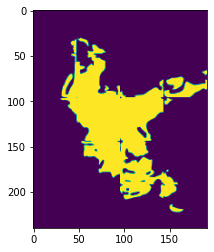

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [45]:
from rasterio.merge import merge
from rasterio.plot import show
import matplotlib.pyplot as plt


src_files_to_mosaic = []

for fp in os.listdir("sr_testing"):
    src = rasterio.open(os.path.join("sr_testing", fp))
    src_files_to_mosaic.append(src)

mosaic, out_trans = merge(src_files_to_mosaic)
show(mosaic)
plt.figure(figsize=(20, 20))

# Final Results

In [65]:
r_segmented_data = sr_model.predict(dlab_hr_test)

r_segmented_data = np.array([resize(image, (48,48), interpolation = cv2.INTER_AREA) for image in r_segmented_data])
dlab_labels_test = np.array([resize(image, (48,48), interpolation = cv2.INTER_AREA) for image in dlab_labels_test])


r_segmented_data = np.argmax(r_segmented_data, axis=3)


dlab_labels_test.shape

(168, 48, 48)

In [66]:
from sklearn.metrics import jaccard_score

y_test = dlab_labels_test.flatten()

y_pred_r = r_segmented_data.flatten()
 



In [67]:
from sklearn.metrics import confusion_matrix
def pixel_iou(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    iou = tp / (tp + fn + fp)
    return iou

In [69]:
pixel_iou(y_test, y_pred_r)

0.5234980646129762